In [1]:
import os

CHECKPOINT_PATH = os.path.join("/home/dimakot55/data/extra_models_weights/sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/home/dimakot55/data/extra_models_weights/sam_vit_h_4b8939.pth ; exist: True


In [3]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [4]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from PIL import Image
import supervision as sv
import numpy as np
from matplotlib import pyplot as plt
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [5]:
mask_generator = SamAutomaticMaskGenerator(sam)

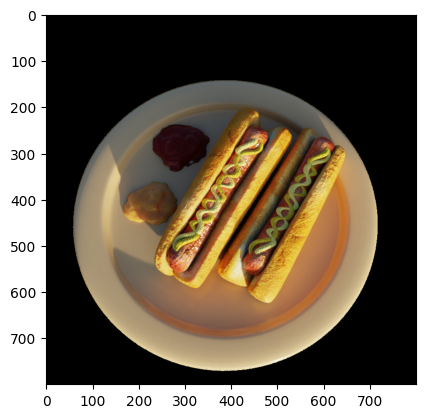

In [6]:


image_rgb = np.array(Image.open("/home/dimakot55/data/nerf_synthetic/hotdog/train/r_41.png").convert('RGB'))
image_bgr = np.array(image_rgb[...,[2,1,0]])
plt.figure()
plt.imshow(image_rgb)
plt.show()


In [7]:
sam_result = mask_generator.generate(image_rgb)

# Initialize surface points

In [8]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # has not effect

import sys
sys.path.append("../")
device="cuda"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

In [9]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])



In [10]:
os.makedirs(args.model_path, exist_ok=True)
content_gaussians = GaussianModel(3)
content_scene = Scene(dataset, content_gaussians, shuffle=True)
content_gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [11]:
content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs/GT_hotdog/chkpnt30000.pth")[0], opt)

In [12]:
# Turn color into coordinates. We will need that to optimize 
# Remove view dependent effects and make all the gaussians opaque. 
# That helps with getting a better mesh
content_gaussians._opacity.data +=  1e6
content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()
content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.
content_gaussians._scaling.data *=  .98


In [13]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))



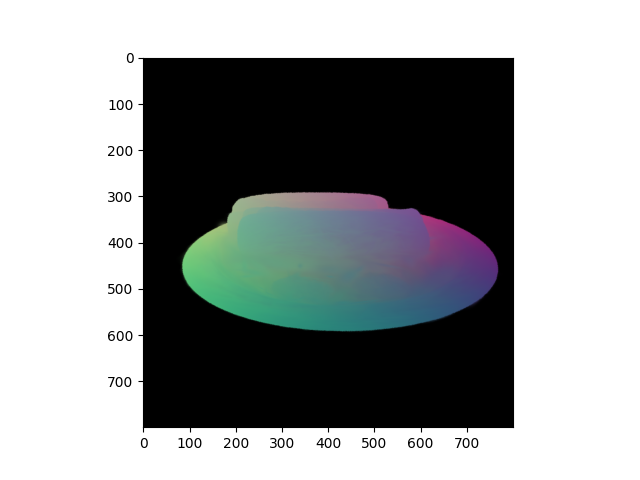

In [14]:

render_pkg = render(viewpoint_cam, content_gaussians, pipe, background)
image, depth, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["depth"], \
    render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


In [15]:

def obtain_surface_pc(viewpoint_stack, gaussians, pipe, background, num_viewpoints=40, pc_size=10000):
    import numpy as np
    import skimage.measure, skimage.morphology
    import scipy

    # 1. Render from different viewpoints and extract points
    all_points = []
    for iter in range(min(num_viewpoints, len(viewpoint_stack))):
        viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        render_pkg_cont = render(viewpoint_cam, gaussians, pipe, background)
        image = render_pkg_cont["render"]
        image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
        image_maxpool = skimage.measure.block_reduce(image_rgb, (3,3,1), np.max)
        mask = scipy.ndimage.binary_erosion(np.max(image_maxpool, axis=-1) > 0.1, structure=None, iterations=5)
        image_clean = image_maxpool * np.expand_dims(mask, axis=-1)
        all_points += list(image_clean[np.min(image_clean, axis=-1)>0.1])
    
    
    # 2. Subsample the points 
    all_points = np.array(all_points)
    all_points_idcs = np.random.choice(range(len(all_points)), size=pc_size, replace=False) 
    all_points = all_points[all_points_idcs]

    # 3. Remove poitns that are too far away from all other points.
    # Compute all pairwise distances between points
    from scipy.spatial import distance
    k=10
    pairwise_distances = distance.cdist(all_points, all_points, 'euclidean')
    # Use np.partition to find the k-th smallest distances for each row
    kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
    kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
    q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.99)
    idcs = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
    all_points = all_points[idcs]

    return all_points
        

In [16]:

content_surface_pc = obtain_surface_pc(viewpoint_stack=viewpoint_stack, 
                               gaussians=content_gaussians, 
                               pipe=pipe, 
                               background=background,
                               num_viewpoints=40)

In [17]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    ax.scatter(content_surface_pc[::kth,0], 
               content_surface_pc[::kth,1], 
               content_surface_pc[::kth,2], c='b', marker='o',s=0.1)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

In [18]:
content_gaussians.restore(torch.load("/home/dimakot55/output_data/gs/GT_hotdog/chkpnt30000.pth")[0], opt)

# Now find a good viewpoint and manually select masks that might be the most useful

In [19]:
import numpy as np
import skimage.measure, skimage.morphology
import scipy
from scipy.spatial import distance


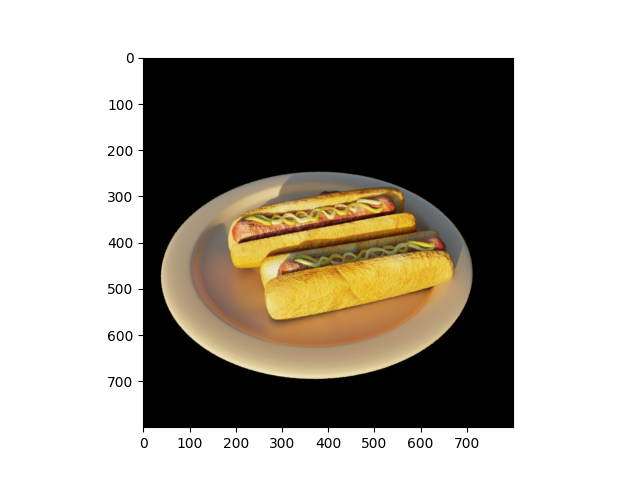

In [20]:
viewpoint_stack=viewpoint_stack
gaussians=content_gaussians
pipe=pipe
background=background
surface_points=content_surface_pc #content_surface_pc2,
num_viewpoints=20
verbose=True




gaussians_features_dc_original = gaussians._features_dc.detach().clone()
gaussians_features_rest_original = gaussians._features_rest.detach().clone()
gaussians_scaling_original = gaussians._scaling.detach().clone()
gaussians_opacity_original = gaussians._opacity.detach().clone()

N = len(surface_points)
# Mask for points(don't really need it, only for debug.
surface_points_masks = np.ones(N, dtype=np.int32)*-1
# Adjacency matrix for surface points. High value indicate that points have been assigned to the 
# same segmentation mask using SAM model.
surface_points_A = np.zeros((N,N), dtype=np.int32)
surface_points_masks_list = []


surface_points_masks = np.ones(N, dtype=np.int32)*-1

# 2. For each new camera viewpoint. Render image_rgb and render image_rgb_as_coords (where we turn color into coordinates)
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
render_pkg = render(viewpoint_cam, gaussians, pipe, background)
image = render_pkg["render"]
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
if verbose:
    plt.figure()
    plt.imshow(image_rgb)
    plt.show(block=False)

# now render rgb_as_coords
gaussians._opacity.data +=  1e6
gaussians._features_dc.data = gaussians._xyz.data.clone().detach().unsqueeze(1)
gaussians._features_rest.data = gaussians._features_rest.data * 0.
gaussians._scaling.data *=  .98
render_pkg = render(viewpoint_cam, gaussians, pipe, background)
image = render_pkg["render"]
image_rgb_as_coords = image.detach().cpu().numpy().transpose(1, 2, 0)

if verbose:
    plt.figure()
    plt.imshow(image_rgb_as_coords)
    plt.show(block=False)

# Now recover original _opacity, _scaling, _features_dc, _features_rest.
gaussians._features_dc.data = gaussians_features_dc_original.detach().clone()
gaussians._features_rest.data = gaussians_features_rest_original.detach().clone()
gaussians._scaling.data = gaussians_scaling_original.detach().clone()
gaussians._opacity.data = gaussians_opacity_original.detach().clone()

# 3. Apply sam to get masks.  
# transform input into uint8
sam_result = mask_generator.generate(np.clip(image_rgb*255., 0., 255.).astype(np.uint8))
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=False)
]
if verbose:
    detections = sv.Detections.from_sam(sam_result=sam_result)
    image_bgr = (np.array(image_rgb[...,[2,1,0]])*255.).astype(np.uint8)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    sv.plot_images_grid(
        images=[image_bgr, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )

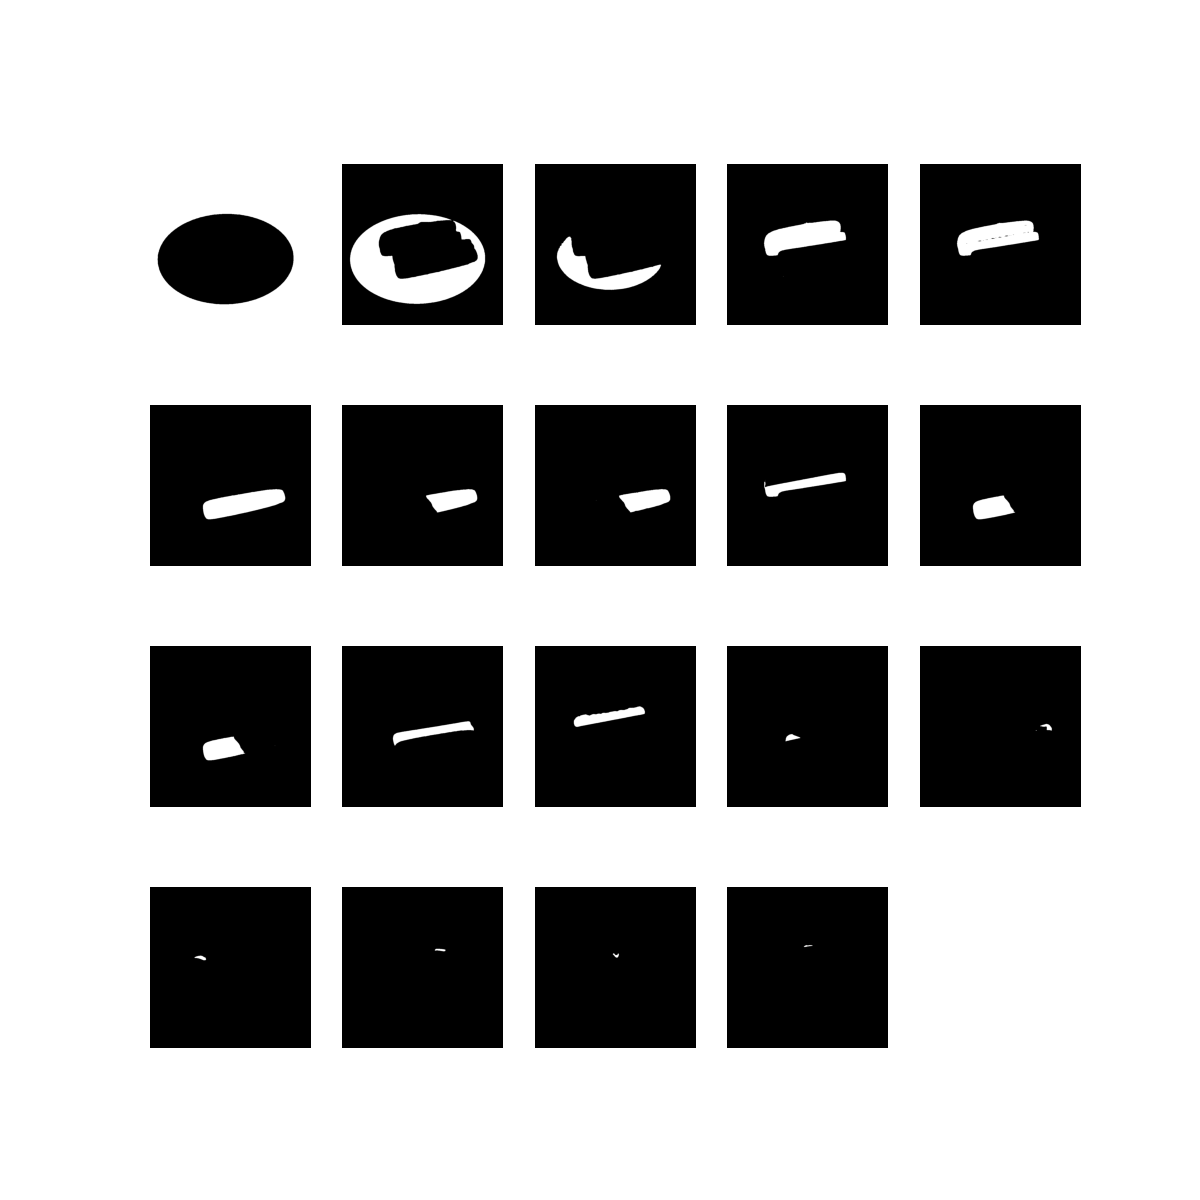

In [21]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(4, 5),
    size=(12, 12)
)

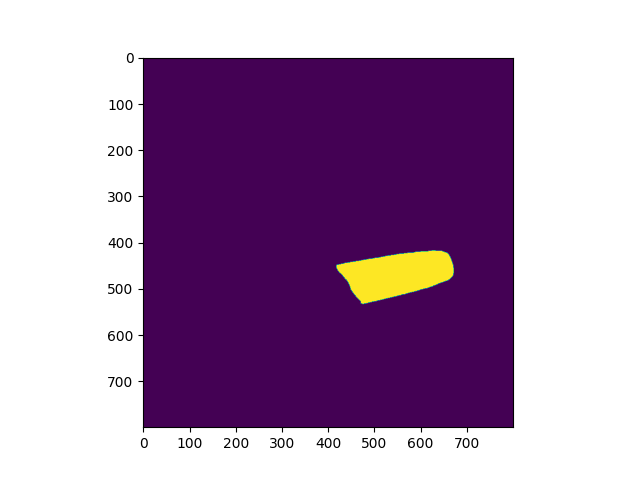

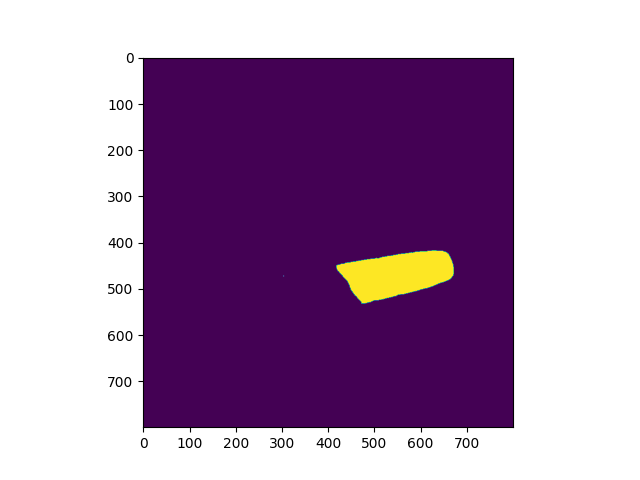

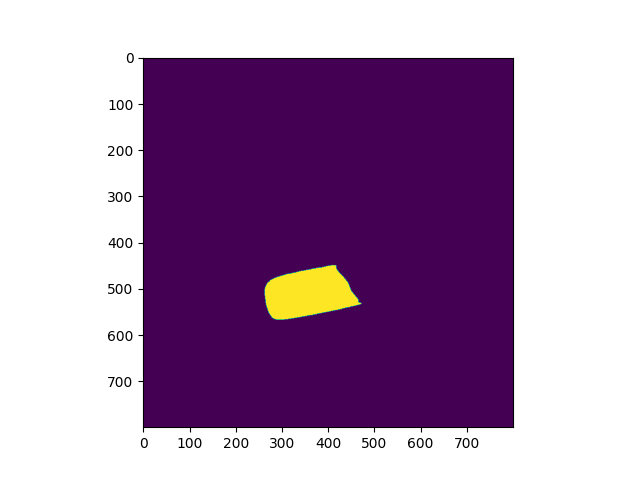

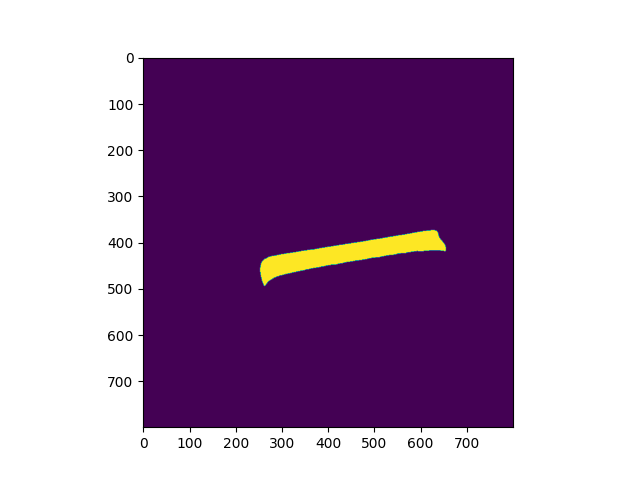

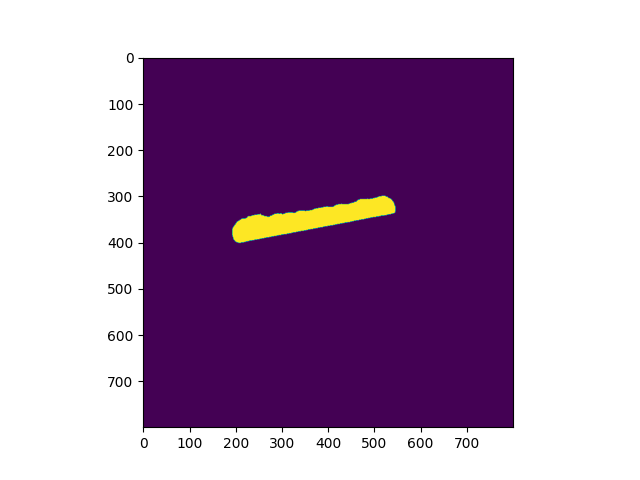

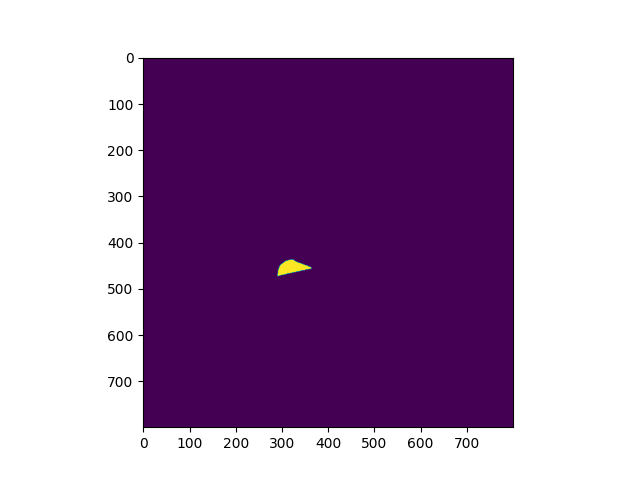

In [22]:
for i in [1, 4,5,6,7,9,11,12,13]:
    plt.figure()
    plt.imshow(masks[i])
    plt.show()

In [61]:
masks[[1, 4,5,6,7,9,11,12,13]]

TypeError: list indices must be integers or slices, not list

In [23]:
#print(len(masks))

masks_points_coords = []
masks_points_labels = []
for mask_idx, mask in tqdm(enumerate([masks[i] for i in [1, 4,5,6,7,9,11,12,13]])):
    masks_points_coords.append(image_rgb_as_coords[np.where(mask)])
    masks_points_labels.append(np.ones(len(masks_points_coords[-1]))*mask_idx)

# Subsample and get 100K points
masks_points_coords = np.concatenate(masks_points_coords, axis=0)
masks_points_labels = np.concatenate(masks_points_labels, axis=0)

idcs = np.random.choice(range(len(masks_points_coords)), size=100_000, replace=False) 
masks_points_coords = masks_points_coords[idcs]
masks_points_labels = masks_points_labels[idcs]

# For each surface point find the nearest SAM mask point and assign its label if the 
# distance is smaller then some threshold.
# CPU Version - pretty slow for large arrays
# pairwise_distances = distance.cdist(mask_points, surface_points, 'euclidean')
# surface_points_nearest_idcs_to_mask = np.argmin(pairwise_distances, axis=1)
# GPU version
pairwise_distances = torch.cdist(
    torch.tensor(surface_points).to(device=device).to(dtype=torch.float16),
    torch.tensor(masks_points_coords).to(device=device).to(dtype=torch.float16),  
    p=2)
surface_points_to_mask_val, surface_points_to_mask_idx = torch.min(pairwise_distances, axis=1)


surface_points_to_mask_val = surface_points_to_mask_val.detach().cpu().numpy()
surface_points_to_mask_idx = surface_points_to_mask_idx.detach().cpu().numpy()


# surface_points_masks[np.where(surface_points_to_mask_val<THRESH)[0]]
# surface_points_masks = masks_points_labels[surface_points_to_mask_idx]

# Find surface points that are close enough (closer then threshold)
THRESH = 2e-2
relevant_surface_points_idcs = np.where(surface_points_to_mask_val<THRESH)[0]
surface_points_masks[relevant_surface_points_idcs] = masks_points_labels[surface_points_to_mask_idx][relevant_surface_points_idcs]

surface_points_masks_list.append(surface_points_masks)
for mask_val in np.unique(surface_points_masks):
    if mask_val != -1:
        idcs = np.where(surface_points_masks==mask_val)[0]
        surface_points_A[np.ix_(idcs, idcs)] += 1

/tmp/ipykernel_3446500/1042952798.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mask_idx, mask in tqdm(enumerate([masks[i] for i in [1, 4,5,6,7,9,11,12,13]])):


0it [00:00, ?it/s]

In [24]:
surface_points_masks

array([0, 1, 0, ..., 2, 1, 0], dtype=int32)

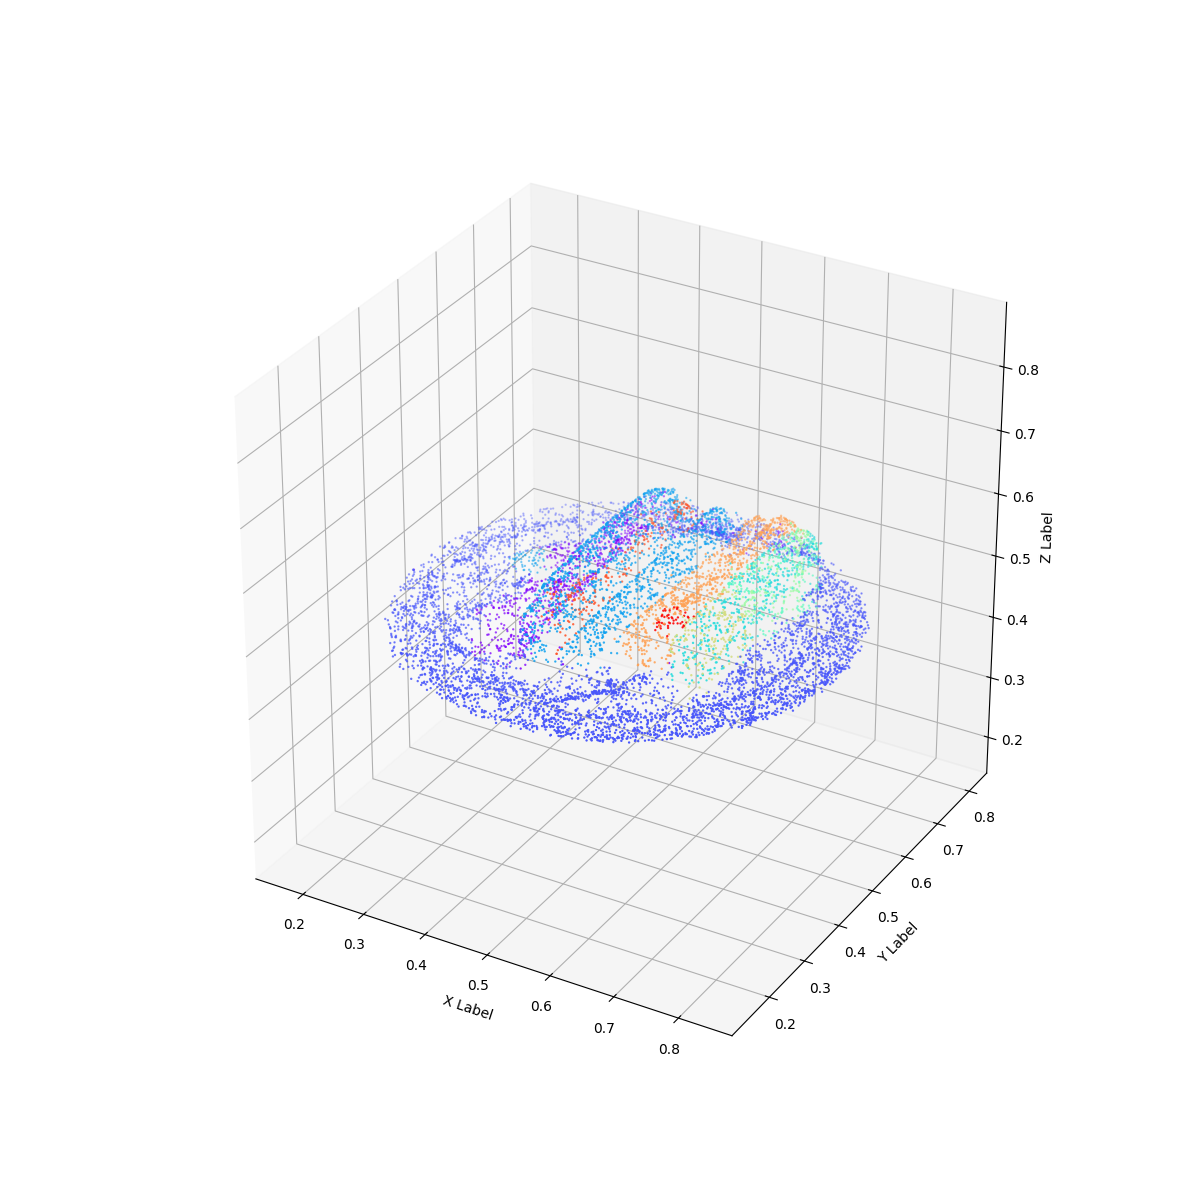

In [25]:
# Create a 3D scatter plot
# Define a colormap (you can choose any other colormap)
colormap = plt.get_cmap('rainbow')

# Normalize the integers to be in the range [0, 1] for colormap mapping
norm = plt.Normalize(surface_points_masks.min(), surface_points_masks.max())

# Map the integers to colors using the colormap
colors = colormap(norm(surface_points_masks))






fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    ax.scatter(content_surface_pc[::kth,0], 
               content_surface_pc[::kth,1], 
               content_surface_pc[::kth,2], c=colors, marker='o',s=0.5)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

# Now visualize each cluster separately.
Iterate over masks. For each guassian in the scene find the nearest mask. 

In [65]:
gaussians._xyz.data

tensor([[ 0.1668,  0.6399,  0.1859],
        [-0.1924,  0.6829,  0.0048],
        [-0.5861,  0.7206, -0.1055],
        ...,
        [ 0.9553, -0.7934, -0.0833],
        [-0.9595, -0.0224, -0.0836],
        [-0.9560,  0.0596, -0.0910]], device='cuda:0')

In [91]:
content_surface_pc_fitted = torch.tensor(content_surface_pc).to(device)
# content_surface_pc_fitted = content_surface_pc_fitted - torch.mean(content_surface_pc_fitted, dim=0, keepdim=True) + \
#         torch.mean(gaussians._xyz.data, dim=0, keepdim=True)
# content_surface_pc_fitted = content_surface_pc_fitted / torch.std(content_surface_pc_fitted) * torch.std(gaussians._xyz.data)


src_min, src_max = torch.min(content_surface_pc_fitted, dim=0)[0], torch.max(content_surface_pc_fitted, dim=0)[0]
trg_min, trg_max = torch.min(gaussians._xyz.data, dim=0)[0], torch.max(gaussians._xyz.data, dim=0)[0]
# content_surface_pc_fitted = content_surface_pc_fitted - torch.mean(content_surface_pc_fitted, dim=0, keepdim=True) + \
#         torch.mean(gaussians._xyz.data, dim=0, keepdim=True)
# content_surface_pc_fitted = content_surface_pc_fitted / torch.std(content_surface_pc_fitted) * torch.std(gaussians._xyz.data)

content_surface_pc_fitted = (content_surface_pc_fitted - src_min) / (src_max-src_min)
content_surface_pc_fitted = content_surface_pc_fitted * (trg_max-trg_min) + trg_min

In [92]:
content_surface_pc_fitted

tensor([[-0.5157, -0.8035, -0.2277],
        [-0.3765,  0.4417, -0.0941],
        [-0.1819,  1.0221, -0.1954],
        ...,
        [ 0.6098,  0.7523, -0.0060],
        [-1.0422,  0.3224, -0.1711],
        [ 0.2807,  0.0789,  0.1090]], device='cuda:0')

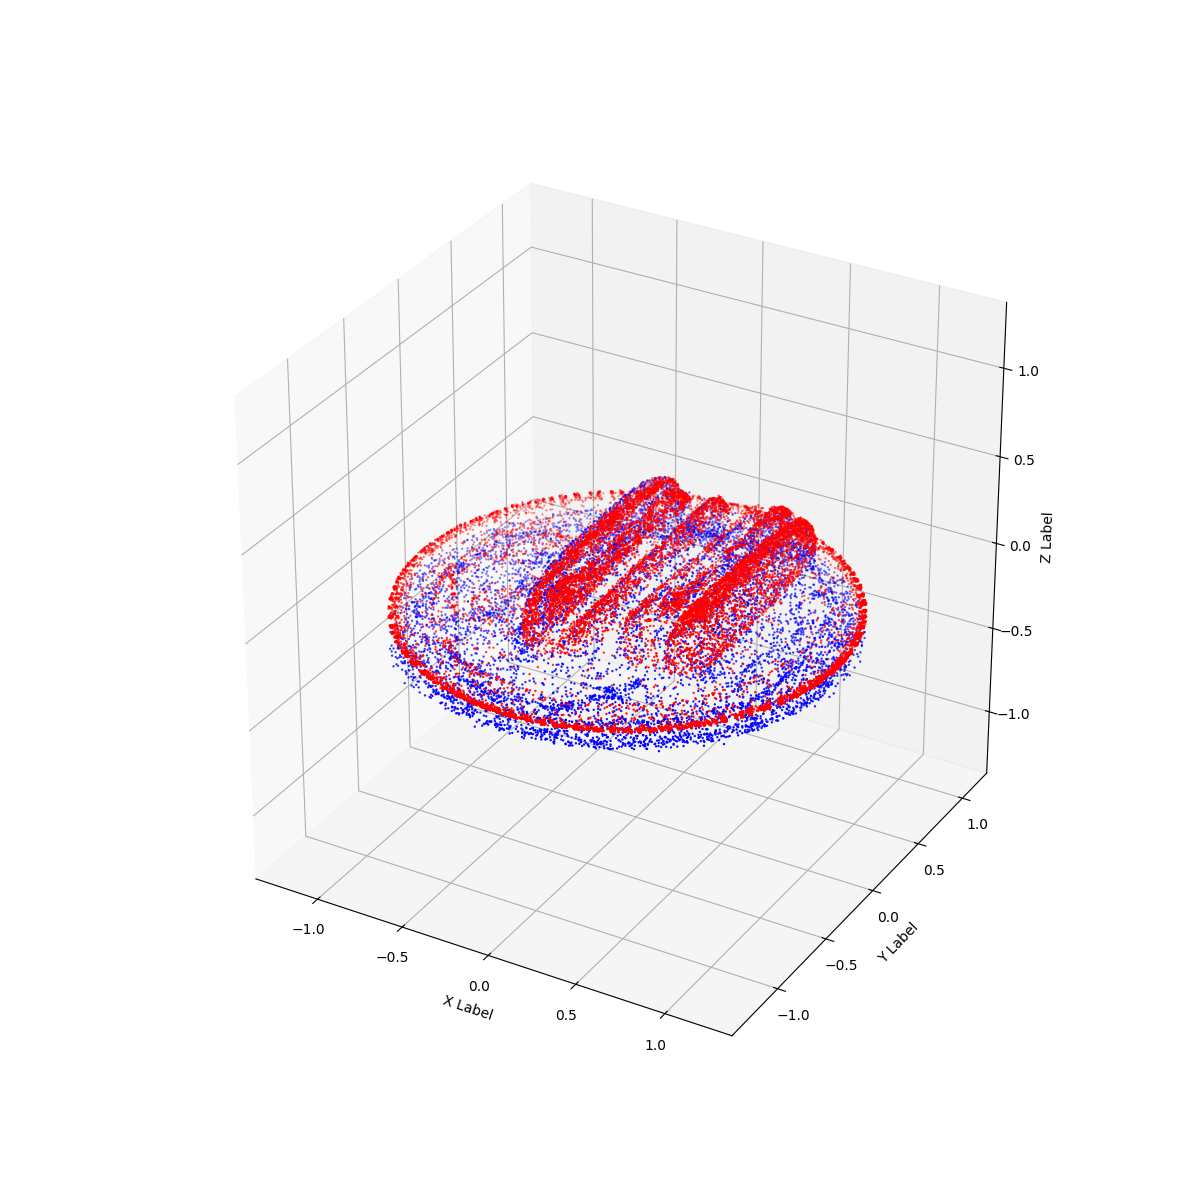

In [94]:

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
kth=1
if True:
    arr = content_surface_pc_fitted.detach().cpu().numpy()
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], c='b', marker='o',s=0.5)

kth=10
if True:
    arr = gaussians._xyz.data.detach().cpu().numpy()
    ax.scatter(arr[::kth,0], 
               arr[::kth,1], 
               arr[::kth,2], c='r', marker='o',s=0.5)



# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()


In [67]:
# Conversion from features_dc to actual color
# Taken from here https://github.com/graphdeco-inria/gaussian-splatting/issues/485
C0 = 0.28209479177387814
R = 0.5 + C0 * f_dc_0

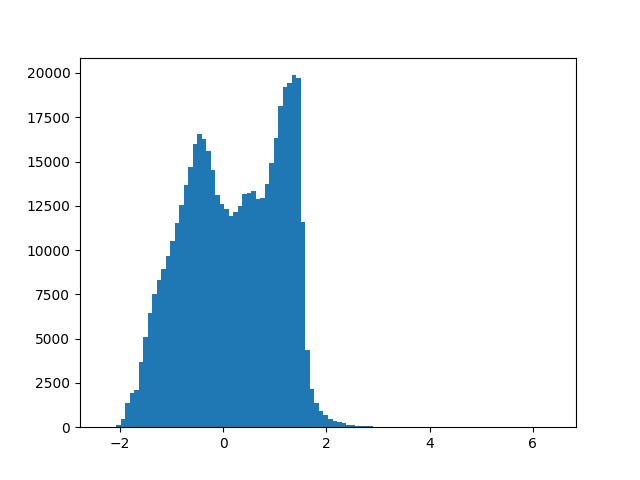

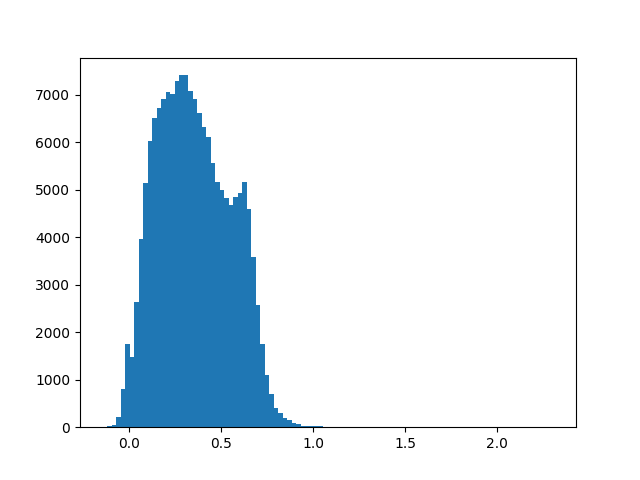

In [79]:
plt.figure()
plt.hist(gaussians._features_dc.data[:,0].detach().cpu().numpy().flatten(), bins=100)
plt.show()


f_dc_0 = gaussians._features_dc.data[:,0].detach().cpu().numpy()[:,2]
R = 0.5 + C0 * f_dc_0
plt.figure()
plt.hist(R, bins=100)
plt.show()


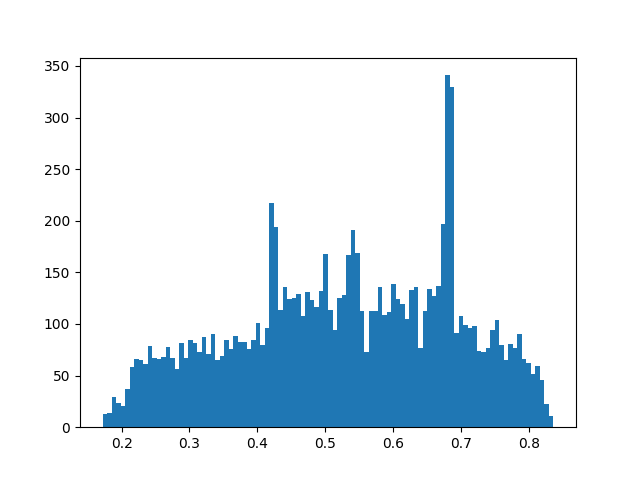

In [80]:
plt.figure()
plt.hist(content_surface_pc[:,0], bins=100)
plt.show()


# Optimize for each mask separately

In [122]:

gaussians_features_dc_original = content_gaussians._features_dc.detach().clone()
gaussians_features_rest_original = content_gaussians._features_rest.detach().clone()
gaussians_scaling_original = content_gaussians._scaling.detach().clone()
gaussians_opacity_original = content_gaussians._opacity.detach().clone()

In [144]:
content_gaussians._opacity.data = gaussians_opacity_original.detach().clone()
content_gaussians._features_dc.data = gaussians_features_dc_original.detach().clone()
content_gaussians._features_rest.data = gaussians_features_rest_original.detach().clone()

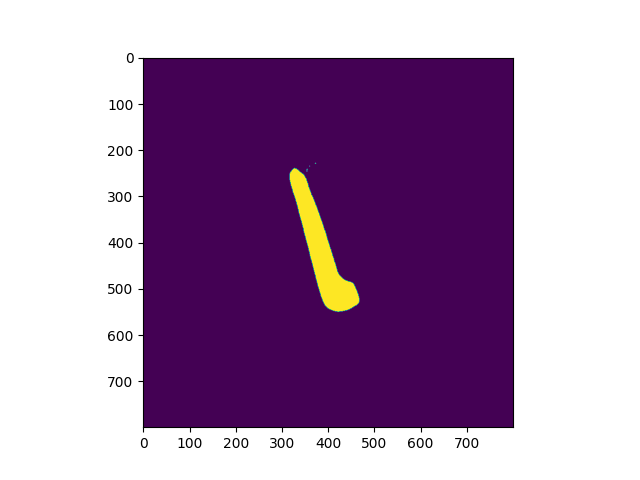

tensor(0.1509, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1379, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1253, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1131, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0900, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0792, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0689, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0507, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0433, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0374, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0323, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0278, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0238, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0204, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0175, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0151, device='cuda:0',

In [141]:


for i in [4]: # [1, 4,5,6,7,9,11,12,13]:
    mask = masks[i]
    plt.figure()
    plt.imshow(mask)
    plt.show()
    content_gaussians._opacity.data = gaussians_opacity_original.detach().clone()
    content_gaussians._features_dc.data = gaussians_features_dc_original.detach().clone()
    content_gaussians._features_rest.data = gaussians_features_rest_original.detach().clone()
    optimizer = torch.optim.Adam([content_gaussians._opacity, 
                                  content_gaussians._features_dc, 
                                  content_gaussians._features_rest], lr=1e-2)
    # optimizer = torch.optim.Adam([content_gaussians._opacity], lr=1e0)
    with torch.no_grad():
        render_pkg = render(viewpoint_cam, content_gaussians, pipe, background)
        image = render_pkg["render"]
        target_img = image*torch.tensor(mask).to(device=device).detach().clone()
    
    
    for iter in range(100):
        render_pkg = render(viewpoint_cam, content_gaussians, pipe, background)
        image = render_pkg["render"]
    
        loss = torch.mean(torch.abs(image - target_img))
        loss.backward()
    
        optimizer.step()
        print(loss)

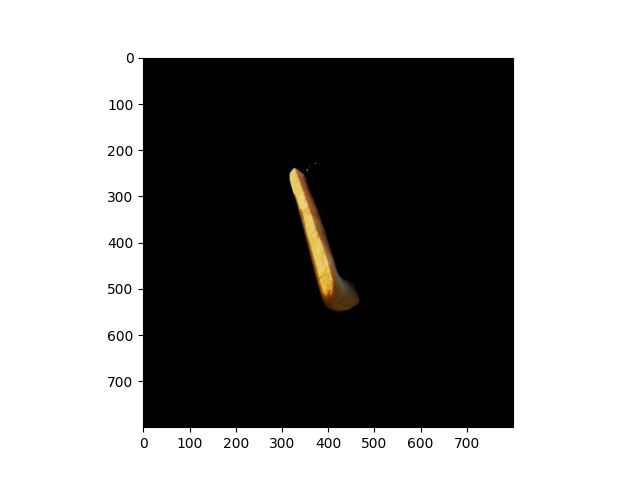

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


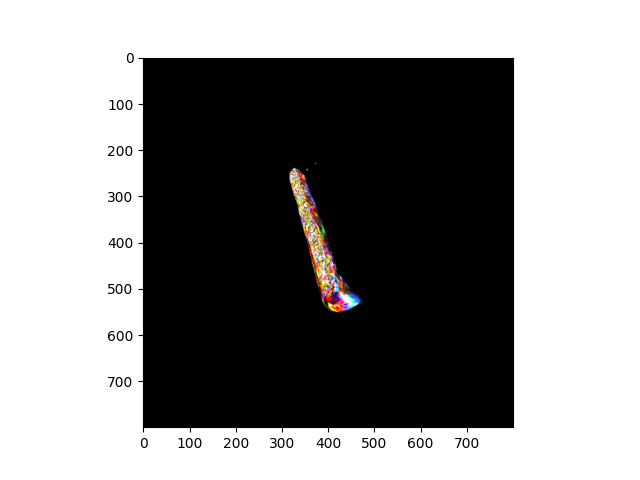

In [142]:

plt.figure()
plt.imshow(target_img.detach().cpu().numpy().transpose(1,2,0))
plt.show()

plt.figure()
plt.imshow(image.detach().cpu().numpy().transpose(1,2,0))
plt.show()


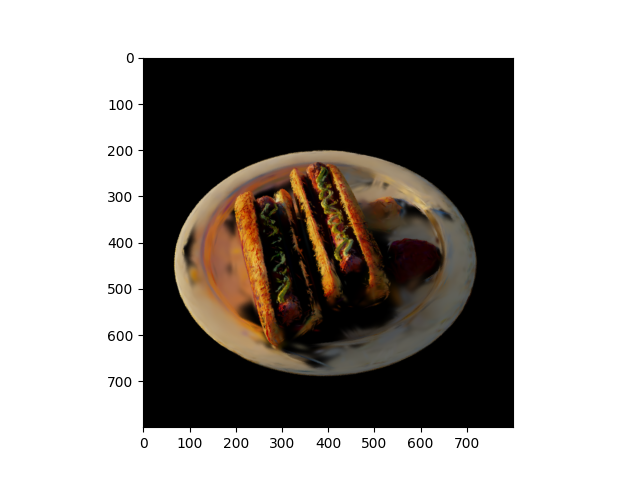

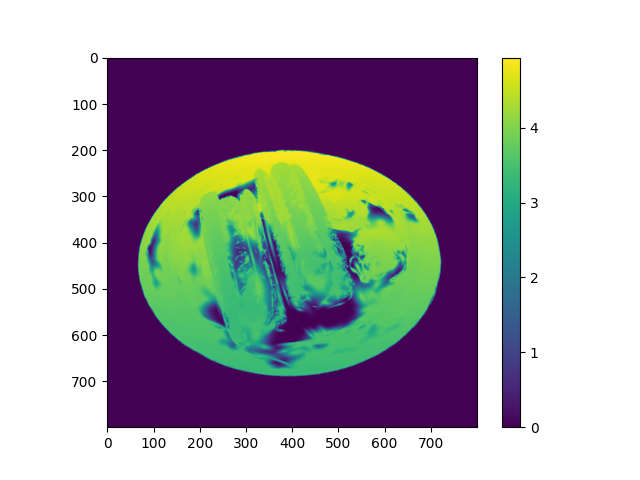

In [108]:

render_pkg = render(viewpoint_cam, content_gaussians, pipe, background)
image, depth, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["depth"], \
    render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

In [ ]:
viewpoint_cam

In [161]:
content_gaussians._opacity.data +=  1e6
content_gaussians._scaling.data *=  .93


In [166]:
content_gaussians._scaling.data *=  .93

In [155]:

viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


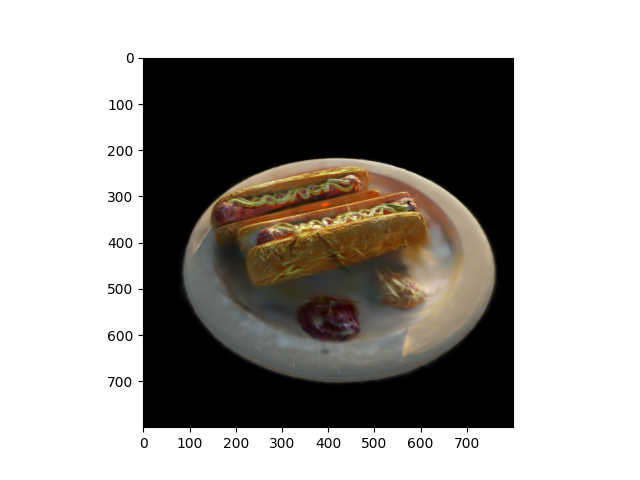

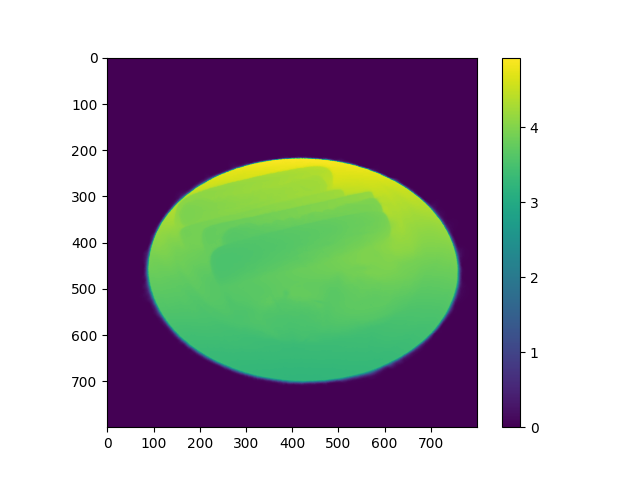

In [167]:


render_pkg = render(viewpoint_cam, content_gaussians, pipe, background)
image, depth, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["depth"], \
    render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()

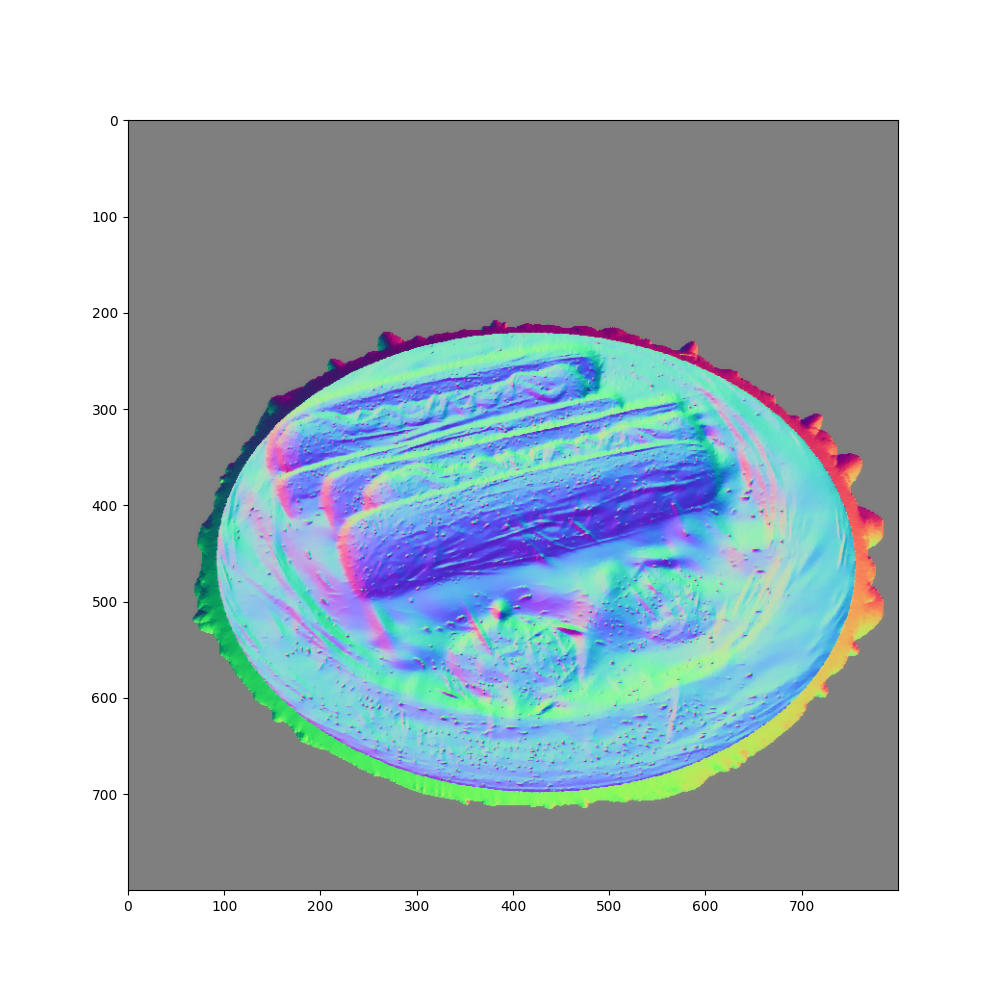

In [168]:

import kornia
K = torch.tensor([[1111, 0, 400],
                  [0, 1111, 400],
                  [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
normals = kornia.geometry.depth.depth_to_normals(depth=depth.unsqueeze(0).unsqueeze(0),
                                                 camera_matrix=K,
                                                 normalize_points=False)
image_normals = normals.squeeze(0)
mins = torch.amin(image_normals, dim=(0, 1, 2), keepdim=True)
maxs = torch.amax(image_normals, dim=(0, 1, 2), keepdim=True)
image_normals = (image_normals - mins) / (maxs - mins + 1e-6)
image_normals.detach().cpu().numpy().transpose(1, 2, 0).shape
# This one is much more efficient
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
image_normals_np = image_normals.detach().cpu().numpy().transpose(1, 2, 0)


# plt.figure(figsize=(10,10))
# plt.imshow(image_normals_np)
# plt.show()

plt.figure(figsize=(10,10))
plt.imshow(denoise_tv_chambolle(image_normals_np, weight=0.05, channel_axis=-1))
plt.show()






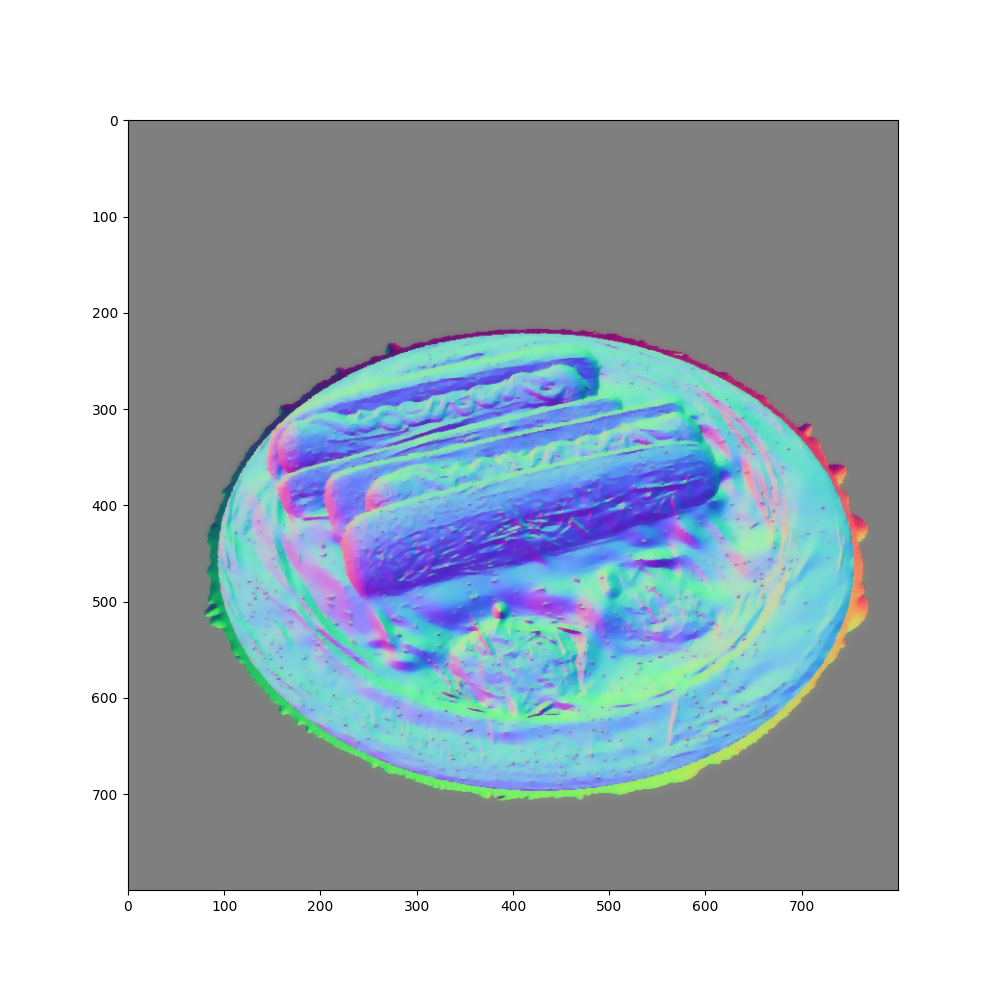

In [165]:

import kornia
K = torch.tensor([[1111, 0, 400],
                  [0, 1111, 400],
                  [0, 0,    1  ]], dtype=torch.float32).unsqueeze(0).to(device="cuda")
normals = kornia.geometry.depth.depth_to_normals(depth=depth.unsqueeze(0).unsqueeze(0),
                                                 camera_matrix=K,
                                                 normalize_points=False)
image_normals = normals.squeeze(0)
mins = torch.amin(image_normals, dim=(0, 1, 2), keepdim=True)
maxs = torch.amax(image_normals, dim=(0, 1, 2), keepdim=True)
image_normals = (image_normals - mins) / (maxs - mins + 1e-6)
image_normals.detach().cpu().numpy().transpose(1, 2, 0).shape
# This one is much more efficient
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
image_normals_np = image_normals.detach().cpu().numpy().transpose(1, 2, 0)


# plt.figure(figsize=(10,10))
# plt.imshow(image_normals_np)
# plt.show()

plt.figure(figsize=(10,10))
plt.imshow(denoise_tv_chambolle(image_normals_np, weight=0.15, channel_axis=-1))
plt.show()




